<a href="https://colab.research.google.com/github/mallika-x/PatternFlow/blob/master/mmwave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from scikitplot.metrics import confusion_matrix
import pickle as pkl
import pandas as pd

In [3]:
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.9.2


In [4]:
# Upload csv files to collab
from google.colab import files
uploaded = files.upload()

Saving Table-C-One-Person.p to Table-C-One-Person.p


In [12]:
def time(year, month, day, hour, minute, second):
    "Returns the timetamp object"
    return (pd.Timestamp(year=year, month=month, day=day, hour=hour, minute=minute, second=second ,tz="Australia/Brisbane"))


def add_labels(mmwave):
    """
    Labels sitting as 0 and standing as 1
    """
    # Iterate over mmwave data
    for index, current_time in enumerate(mmwave["mmwave_timestamp"]):
        if current_time <= time(2023, 1, 6, 14, 22, 24) and current_time >= time(2023, 1, 6, 14, 19, 24):
            mmwave["class"][index] = 0
        elif current_time <= time(2023, 1, 6, 14, 25, 51) and current_time >= time(2023, 1, 6, 14, 22, 51):
            mmwave["class"][index] = 0
        elif current_time <= time(2023, 1, 6, 14, 28, 56) and current_time >= time(2023, 1, 6, 14, 25, 56):
            mmwave["class"][index] = 1
        elif current_time <= time(2023, 1, 6, 14, 32, 0) and current_time >= time(2023, 1, 6, 14, 29, 0):
            mmwave["class"][index] = 1
    
    return mmwave


def add_coordinates(mmwave):
    """
    Populates x,y,x columns
    """
    # Iterate over mmwave data
    for index, object in enumerate(mmwave["objects"]):
        mmwave["x"][index] = object[0]['position'][0]
        mmwave["y"][index] = object[0]['position'][1]
        mmwave["z"][index] = object[0]['position'][2]
    
    return mmwave


def model_metrics(y_test, y_pred, type):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title(f'Confusion Matrix: {type}', fontsize=18)
    plt.show()

In [24]:
# Load mmwave data
with open(r"Table-C-One-Person.p", "rb") as f:
    object = pkl.load(f)
mmwave = pd.DataFrame(object)

# Keep selected columns
mmwave = mmwave[['mmwave_timestamp', 'objects']]
# Add column for class and coordinates
mmwave["class"] = ""
mmwave["x"] = ""
mmwave["y"] = ""
mmwave["z"] = ""

# Convert unix time to datetime
mmwave['mmwave_timestamp'] = mmwave['mmwave_timestamp'].astype('int64')
mmwave['mmwave_timestamp'] = pd.to_datetime(mmwave['mmwave_timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Australia/Brisbane') # Changing the values of the column

# Label the data as sitting and standing
mmwave = add_labels(mmwave)

# Add coordinate data
mmwave = add_coordinates(mmwave)

# Remove rows that don't fall in protocol
mmwave = mmwave.loc[(mmwave["class"] == 0) | (mmwave["class"] == 1)]

# Shuffle dataframe
mmwave = mmwave.sample(frac = 1)

# Split into data and labels
data = mmwave[['x', 'y', 'z']]
data = data.values
data = data.astype('float32')
labels = mmwave['class']
labels = labels.astype('int')
labels = labels.values

# Split into test and training sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=12345)

<ipython-input-12-6e83f285b172>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmwave["class"][index] = 0
<ipython-input-12-6e83f285b172>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmwave["class"][index] = 0
<ipython-input-12-6e83f285b172>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmwave["class"][index] = 1
<ipython-input-12-6e83f285b172>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(12, input_shape=(3,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(train_data, train_labels, epochs=50, batch_size=10)

# evaluate the keras model
_, accuracy = model.evaluate(train_data, train_labels)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/50
264/264 [==============================] - 1s 2ms/step - loss: 0.6744 - accuracy: 0.6472
Epoch 2/50
264/264 [==============================] - 0s 2ms/step - loss: 0.6500 - accuracy: 0.6658
Epoch 3/50
264/264 [==============================] - 0s 2ms/step - loss: 0.6268 - accuracy: 0.6472
Epoch 4/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5959 - accuracy: 0.7140
Epoch 5/50
264/264 [==============================] - 1s 2ms/step - loss: 0.5607 - accuracy: 0.7769
Epoch 6/50
264/264 [==============================] - 1s 3ms/step - loss: 0.5133 - accuracy: 0.8767
Epoch 7/50
264/264 [==============================] - 1s 2ms/step - loss: 0.4554 - accuracy: 0.9511
Epoch 8/50
264/264 [==============================] - 1s 2ms/step - loss: 0.4004 - accuracy: 0.9666
Epoch 9/50
264/264 [==============================] - 0s 2ms/step - loss: 0.3370 - accuracy: 0.9920
Epoch 10/50
264/264 [==============================] - 0s 2ms/step - loss: 0.2779 - accuracy: 0.9951

83/83 [==============================] - 0s 3ms/step
Training error = 0.061592424105014885
21/21 [==============================] - 0s 3ms/step
Testing error = 0.06741998624632421



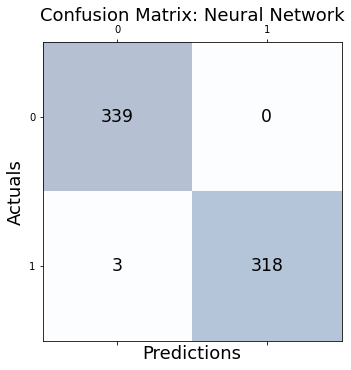

In [35]:
# Calculate training error
from sklearn.metrics import mean_squared_error
from numpy import sqrt 

train_preds = (model.predict(train_data) > 0.5).astype(int)
mse = mean_squared_error(train_labels, train_preds)
rmse = sqrt(mse)
print(f"Training error = {rmse}")

# Test model
test_preds = (model.predict(test_data) > 0.5).astype(int)
mse = mean_squared_error(test_labels, test_preds)
rmse = sqrt(mse)
print(f"Testing error = {rmse}\n")
model_metrics(test_labels, test_preds, "Neural Network")